In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
from torch.optim.lr_scheduler import StepLR
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
def f_hat(experiment):
    if experiment == "1D_linear":
        f = lambda x, theta: x * theta
    elif experiment == "1D_nonlinear":
        f = lambda x, theta: torch.sin(x * theta)
    if experiment == "2D_linear":
        f = lambda x, theta: (x @ theta)
    elif experiment == "2D_nonlinear":
        f = lambda x, theta: torch.sin(x @ theta) 
    return f

In [5]:
def theta_hat(experiment):
    if experiment == "linear":
        theta_hat = lambda beta, alpha: beta * alpha
    elif experiment == "nonlinear":
        theta_hat = lambda beta, alpha: torch.sin(beta * alpha) 
    return theta_hat


def h_hat(f_experiment, theta_experiment):
    f = f_hat(f_experiment)
    theta_f = theta_hat(theta_experiment)
    def hf(x,alpha,beta):
        theta = theta_f(beta, alpha)
        return f(x,theta)
    return hf

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self,name,experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.experiment = experiment
    
    def fit(self, f, env_dict, alpha):        
        """Fit the coefficients of a function f. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        theta = torch.rand(d, requires_grad=True)
        optimizer = torch.optim.Adam([theta], lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'],f(env_dict[e]['x'], theta)) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            optimizer.zero_grad()
            cvar.backward()
            optimizer.step()
            scheduler.step()
            #if (epoch + 1) % 10 == 0:
            #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return theta.detach()
    
    def fit_independent_h_loop(self, h, env_dict):
        """Fit the coefficients of a function h in independent optimization. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        beta = torch.randn(d, requires_grad=True)
        optimizer = torch.optim.Adam([beta], lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for alpha in torch.arange(0,1,0.05):
            for epoch in range(num_epochs): 
                risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha, beta)) for e in env_dict.keys()])
                cvar = self.aggregator.aggregate(risks, alpha)
                optimizer.zero_grad()
                cvar.backward()
                optimizer.step()
                scheduler.step()
                #if (epoch + 1) % 10 == 0:
                #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return beta.detach()
    
    def fit_independent_h_probablistic(self, h, env_dict):
        """Fit the coefficients of a function h in independent optimization  with alpha'~U[0.05,1]. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        beta = torch.randn(d, requires_grad=True)
        optimizer = torch.optim.Adam([beta], lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for epoch in range(num_epochs): 
            alpha = dist.Uniform(0,1).sample()
            risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha, beta)) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            optimizer.zero_grad()
            cvar.backward()
            optimizer.step()
            scheduler.step()
            #if (epoch + 1) % 10 == 0:
            #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return beta.detach()
    
    
    def objective_h(self, risks, alpha_prime):
        def pdf_normal_distribution(x, alpha_prime):
            # Create a normal distribution centered at alpha' with std. 1 at alpha'
            likelihood = dist.normal.Normal(loc=alpha_prime, scale=alpha_prime)
            # Calculate the probability density at the point x
            pdf = likelihood.log_prob(x).exp()
            return pdf
        alphas = dist.Uniform(0,1).sample((1000,1))
        objective = 0
        weights = pdf_normal_distribution(alphas, alpha_prime)
        cvars = torch.stack([self.aggregator.aggregate(risks,alpha) for alpha in alphas])
        objective = (weights * cvars).mean()
        return objective
    
    def fit_h(self, h, env_dict):
        """Fit the coefficients of a function h in optimization. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs=200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        beta = torch.rand(d, requires_grad=True)
        print("beta init:", beta)
        optimizer = torch.optim.Adam([beta], lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
        for epoch in range(num_epochs): 
            alpha_prime = dist.Uniform(0.05,1).sample()
            risks = torch.stack([loss_fn(env_dict[e]['y'],h(env_dict[e]['x'], alpha_prime, beta)) for e in env_dict.keys()])
            loss = self.objective_h(risks, alpha_prime)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            print("epoch: ",epoch, "beta: ", beta, "loss: ", loss.item())
            #if (epoch + 1) % 10 == 0:
            #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return beta.detach()

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator_1D:
    
    """ This class generates the 1D simulation data. """
    

    def __init__(self, num_envs = 25, size_train = (1000,1), size_test= (100,1), theta_dist="uniform", experiment="1D_linear"):
        
        """ Construct the aggregation function.
        
        Parameters
        -----------
        experiment : str, optional
            the name of the experimental setting (whether we want f to be linear n X or non-linear)
        num_envs : int, optional
            the number of environments
        size : tuple, optional
            the size of the datset (number of observations, number of features)
        theta : str, optional
            the distrubution from which we sample the true thetas for each environment
        """
        
        self.num_envs_train = num_envs
        self.num_envs_test = int(num_envs/10)
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.experiment = experiment
    
    def generate(self, f) -> dict:           
        """Aggregates a list of risks. 

        Returns
        ------
        env_dict : dict
        Examples
        --------
        >>> data_generator_1D(num_envs = 250, size = (100,1), theta="uniform", experiment="1D_linear").generate()
        """
        env_list_train = [f'e_{i}' for i in range(1,self.num_envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.num_envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample()
            x_train = dist.normal.Normal(loc=1, scale=0.5).sample(self.size_train)
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample(self.size_train)
            y_train = f(x_train,theta_true) + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample()
            x_test = dist.normal.Normal(loc=1, scale=0.5).sample(self.size_test)
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample(self.size_test)
            y_test = f(x_test,theta_true)+noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

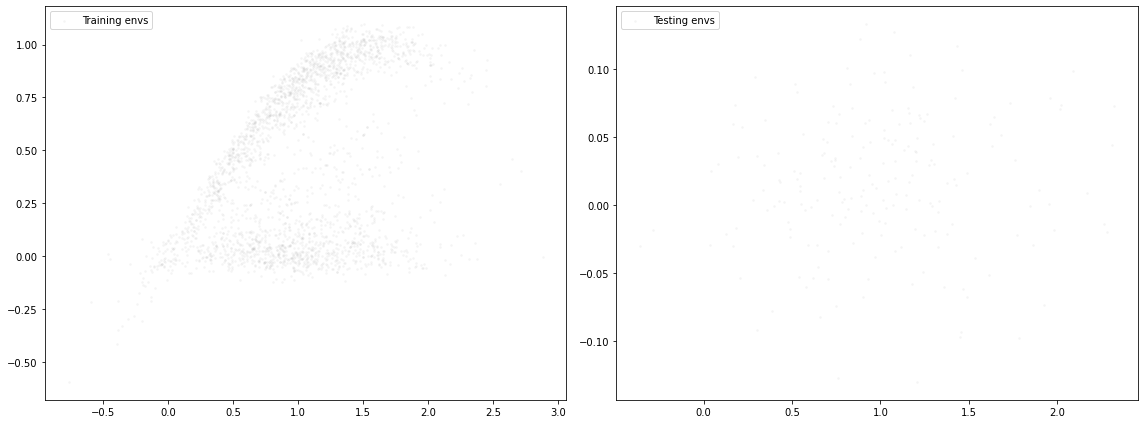

In [9]:
# Intitialize the experiment and generate the data
num_envs=25
size_train, size_test = (100,1) , (100,1)
theta_dist="beta" 
experiment="1D_nonlinear"
theta_experiment = "nonlinear"
rho="cvar"

f = f_hat(experiment)
h = h_hat(experiment, theta_experiment)
data_generator = data_generator_1D(num_envs, size_train, size_test, theta_dist, experiment)
data_dict_train, data_dict_test = data_generator.generate(f)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
X_train = torch.stack([data_dict_train[e]['x'] for e in data_dict_train.keys()])
X_train = np.array(X_train).reshape(-1,1)
Y_train = torch.stack([data_dict_train[e]['y'] for e in data_dict_train.keys()])
Y_train = np.array(Y_train).reshape(-1,1)
ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

ax = axs[1]
X_test = torch.stack([data_dict_test[e]['x'] for e in data_dict_test.keys()])
X_test = np.array(X_test).reshape(-1,1)
Y_test = torch.stack([data_dict_test[e]['y'] for e in data_dict_test.keys()])
Y_test = np.array(Y_test).reshape(-1,1)
ax.scatter(y=Y_test, x=X_test, s=3, c="grey", alpha=0.05, label="Testing envs")
ax.legend(loc='upper left')
fig.tight_layout()

  0%|          | 0/19 [00:00<?, ?it/s]

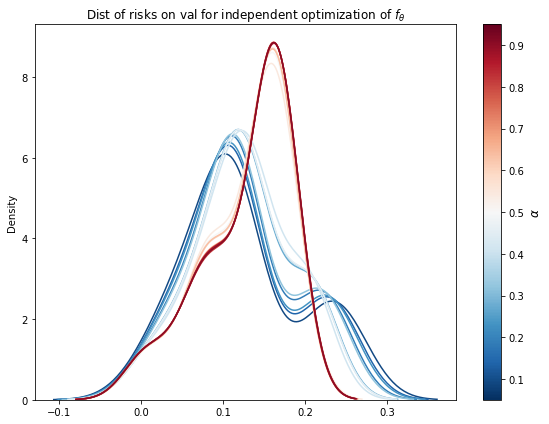

In [10]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1

for i in tqdm(rg):
    theta = ARM_Regression(name=rho, experiment=experiment).fit(f, data_dict_train, i/100)  
    
    risks = torch.stack([loss_fn(data_dict_train[e]['y'], f(data_dict_train[e]['x'], theta)) for e in data_dict_train.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
#ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")
ax.set_title(r"Dist of risks on val for independent optimization of $f_\theta$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

  0%|          | 0/19 [00:00<?, ?it/s]

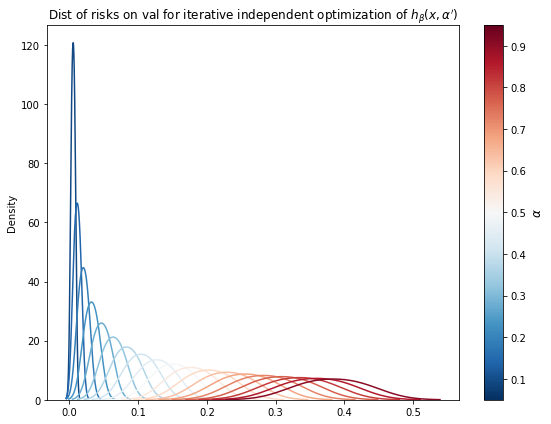

In [11]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
beta_hat = ARM_Regression(name=rho, experiment=experiment).fit_independent_h_loop(h, data_dict_train)  
for i in tqdm(rg):
    #theta = thetafunction(beta_hat, i/100)
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100,beta_hat)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
#ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")
ax.set_title(r"Dist of risks on val for iterative independent optimization of $h_\beta(x,\alpha')$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

  0%|          | 0/19 [00:00<?, ?it/s]

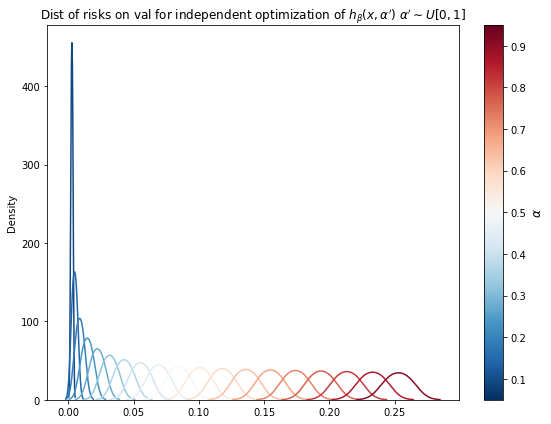

In [12]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
beta_hat = ARM_Regression(name=rho, experiment=experiment).fit_independent_h_probablistic(h, data_dict_train)  
for i in tqdm(rg):
    #theta = thetafunction(beta_hat, i/100)
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100,beta_hat)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
#ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")
ax.set_title(r"Dist of risks on val for independent optimization of $h_\beta(x,\alpha')$ $\alpha' \sim U[0,1]$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

beta init: tensor([0.2377], requires_grad=True)
epoch:  0 beta:  tensor([0.2477], requires_grad=True) loss:  0.22272145748138428
epoch:  1 beta:  tensor([0.2576], requires_grad=True) loss:  0.16864006221294403
epoch:  2 beta:  tensor([0.2675], requires_grad=True) loss:  0.11641521751880646
epoch:  3 beta:  tensor([0.2775], requires_grad=True) loss:  0.24406859278678894
epoch:  4 beta:  tensor([0.2874], requires_grad=True) loss:  0.19121885299682617
epoch:  5 beta:  tensor([0.2968], requires_grad=True) loss:  0.42010176181793213
epoch:  6 beta:  tensor([0.3064], requires_grad=True) loss:  0.24463480710983276
epoch:  7 beta:  tensor([0.3156], requires_grad=True) loss:  0.39764177799224854
epoch:  8 beta:  tensor([0.3247], requires_grad=True) loss:  0.07211527228355408
epoch:  9 beta:  tensor([0.3341], requires_grad=True) loss:  0.26174697279930115
epoch:  10 beta:  tensor([0.3435], requires_grad=True) loss:  0.23311100900173187
epoch:  11 beta:  tensor([0.3524], requires_grad=True) loss:

epoch:  100 beta:  tensor([0.6358], requires_grad=True) loss:  0.08575990796089172
epoch:  101 beta:  tensor([0.6363], requires_grad=True) loss:  0.08557626605033875
epoch:  102 beta:  tensor([0.6366], requires_grad=True) loss:  0.08547718822956085
epoch:  103 beta:  tensor([0.6371], requires_grad=True) loss:  0.14127779006958008
epoch:  104 beta:  tensor([0.6374], requires_grad=True) loss:  0.08645183593034744
epoch:  105 beta:  tensor([0.6376], requires_grad=True) loss:  0.08600115776062012
epoch:  106 beta:  tensor([0.6380], requires_grad=True) loss:  0.21085737645626068
epoch:  107 beta:  tensor([0.6384], requires_grad=True) loss:  0.3008597493171692
epoch:  108 beta:  tensor([0.6387], requires_grad=True) loss:  0.08770964294672012
epoch:  109 beta:  tensor([0.6390], requires_grad=True) loss:  0.4246891438961029
epoch:  110 beta:  tensor([0.6395], requires_grad=True) loss:  0.2796037793159485
epoch:  111 beta:  tensor([0.6397], requires_grad=True) loss:  0.08551353961229324
epoch: 

  0%|          | 0/19 [00:00<?, ?it/s]

tensor([0.0326])
tensor([0.0653])
tensor([0.0979])
tensor([0.1305])
tensor([0.1632])
tensor([0.1958])
tensor([0.2285])
tensor([0.2611])
tensor([0.2937])
tensor([0.3264])
tensor([0.3590])
tensor([0.3916])
tensor([0.4243])
tensor([0.4569])
tensor([0.4895])
tensor([0.5222])
tensor([0.5548])
tensor([0.5875])
tensor([0.6201])


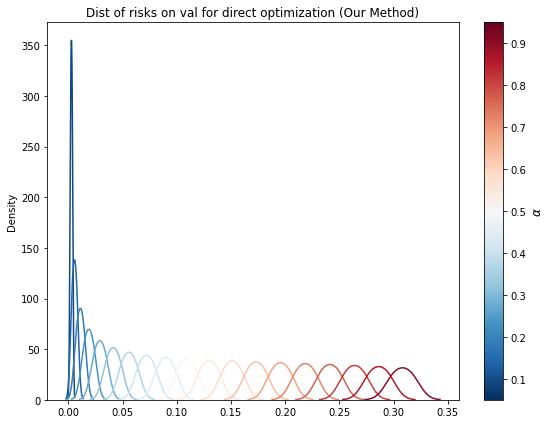

In [13]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
beta_hat = ARM_Regression(name=rho, experiment=experiment).fit_h(h, data_dict_train) 
print("beta", beta_hat)
for i in tqdm(rg):
    theta = theta_hat("linear")(beta_hat, i/100)
    print(theta)
    risks = torch.stack([loss_fn(data_dict_test[e]['y'], h(data_dict_test[e]['x'],i/100,beta_hat)) for e in data_dict_test.keys()])
    cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)
             
    sns.kdeplot(np.array(risks), ax=ax,color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = theta[0]
    results.at[i, "cvar"] = cvar_emp
    j+=1
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on val for direct optimization (Our Method)")

norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()